<a href="https://colab.research.google.com/github/Rocco000/OncoVision/blob/main/Scripts/GAApproach2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #Connect to Google Drive

Run the required scripts

In [ ]:
from google.colab import auth
from googleapiclient.discovery import build

#To authenticate the user that run the script in order to use the correct path
auth.authenticate_user()
drive_service = build('drive', 'v3')

#Get user information
about = drive_service.about().get(fields='user').execute()
user_email = about['user']['emailAddress']
script_owner = False

if user_email =="rocco.iul2000@gmail.com":
  script_owner = True
  #Run the .ipynb file
  %run '/content/drive/MyDrive/SE4AI/Scripts/DatasetLoader.ipynb'
  %run '/content/drive/MyDrive/SE4AI/Scripts/ModelArchitecture2.ipynb'
  %run '/content/drive/MyDrive/SE4AI/Scripts/TrainModel.ipynb'
else:
  %run '/content/drive/MyDrive/LinkToOncoVision/SE4AI/Scripts/DatasetLoader.ipynb'
  %run '/content/drive/MyDrive/LinkToOncoVision/SE4AI/Scripts/ModelArchitecture2.ipynb'
  %run '/content/drive/MyDrive/LinkToOncoVision/SE4AI/Scripts/TrainModel.ipynb'

Import necessary libraries

In [ ]:
!pip install pygad
import torch
import pandas as pd
import pygad
import csv
import random
import numpy as np
import os
import matplotlib.pyplot as plt

# Genetic Algorithm (1° approach)
Our **objective function**:
> max w * accuracy+(1-w) * recall where w=0.4

Our **valuation function** is equal to objective funtion.

Check validity

In [ ]:
def check_validity(solution):
  #Computing the input size of the first nn.Linear

  width_in, height_in, size = size_nn_linear_calculator(layer_type=1, width=600, height=450, channels=None) # first conv2d
  i = 0
  for element in solution:
    if element == 1:
      #conv-32
      width_in, height_in, size = size_nn_linear_calculator(layer_type=1, width=width_in, height=height_in, channels=None)
    elif element == 2:
      #conv-16
      width_in, height_in, size = size_nn_linear_calculator(layer_type=2, width=width_in, height=height_in, channels=None)
    elif element == 3:
      #conv-8
      width_in, height_in, size = size_nn_linear_calculator(layer_type=3, width=width_in, height=height_in, channels=None)
    elif element == 4:
      #conv-4
      width_in, height_in, size = size_nn_linear_calculator(layer_type=4, width=width_in, height=height_in, channels=None)
    elif element == 5:
      #max-3
      #Find the last convolutional layer before the actual layer to define the number of output channels
      j = i-1
      num_channels = 32 #because our first layer is a conv-32
      flag = False
      while j>0 and (not flag):
        if solution[j] == 1:
          num_channels = 32
          flag = True
        elif solution[j] == 2:
          num_channels = 16
          flag = True
        elif solution[j] == 3:
          num_channels = 8
          flag = True
        elif solution[j] == 4:
          num_channels = 4
          flag = True
        j = j-1
      width_in, height_in, size = size_nn_linear_calculator(layer_type=5, width=width_in, height=height_in, channels=num_channels)
    elif element == 6:
      #max-2
      #Find the last convolutional layer before the actual layer to define the number of output channels
      j = i-1
      num_channels = 32 #because our first layer is a conv-32
      flag = False
      while j>0 and (not flag):
        if solution[j] == 1:
          num_channels = 32
          flag = True
        elif solution[j] == 2:
          num_channels = 16
          flag = True
        elif solution[j] == 3:
          num_channels = 8
          flag = True
        elif solution[j] == 4:
          num_channels = 4
          flag = True
        j = j-1
      width_in, height_in, size = size_nn_linear_calculator(layer_type=6, width=width_in, height=height_in, channels=num_channels)
    elif element == 7:
      #avg-3
      #Find the last convolutional layer before the actual layer to define the number of output channels
      j = i-1
      num_channels = 32 #because our first layer is a conv-32
      flag = False
      while j>0 and (not flag):
        if solution[j] == 1:
          num_channels = 32
          flag = True
        elif solution[j] == 2:
          num_channels = 16
          flag = True
        elif solution[j] == 3:
          num_channels = 8
          flag = True
        elif solution[j] == 4:
          num_channels = 4
          flag = True
        j = j-1
      width_in, height_in, size = size_nn_linear_calculator(layer_type=7, width=width_in, height=height_in, channels=num_channels)
    elif element == 8:
      #avg-2
      #Find the last convolutional layer before the actual layer to define the number of output channels
      j = i-1
      num_channels = 32 #because our first layer is a conv-32
      flag = False
      while j>0 and (not flag):
        if solution[j] == 1:
          num_channels = 32
          flag = True
        elif solution[j] == 2:
          num_channels = 16
          flag = True
        elif solution[j] == 3:
          num_channels = 8
          flag = True
        elif solution[j] == 4:
          num_channels = 4
          flag = True
        j = j-1
      width_in, height_in, size = size_nn_linear_calculator(layer_type=8, width=width_in, height=height_in, channels=num_channels)

    i = i+1

  size = int(size)
  if size<8:
    return False, 0
  else:
    return True, size

def replace_solution(solution):
  temp = list()
  flag = False

  while not flag:
    #Define a new solution in a random manner
    for i in range(10):
      random_number = random.randint(1, 11)
      temp.append(random_number)

    flag, size = check_validity(temp)

  new_solution = solution[:4]
  new_solution.extend(temp)
  return new_solution, size

# Assessment of solutions
**After the mutation step** we will evalutate the solutions and store their fitness value in a csv file.

If we obtain a solution that has the same configuration of another solution stored in "AllSolutions.csv", we do not retrain the model as there is a high probability that the solutions have the same performance (in this way we reduce the time consumption)

In [ ]:
max_fitness = 0
num_step = None

def evaluate_solutions(num_generation, population, ga_instance):
  print("***************************************************************")
  print("We are at the ",num_generation," generation step")
  population_list = population.tolist()
  global max_fitness
  global num_step
  step_value = 0
  sum = 0

  #Make a copy to handle the no valid solutions
  population_copy = population_list.copy()
  copy_flag = False

  if num_step is None:
    step_value = num_generation
  else:
    step_value = num_step + num_generation

  #Define the files path to check if this solution already exists (less time consumption) and to store the model configuration of the best solution
  path_parameters = ""
  file_path1 = file_path2 = file_path3 = ""
  if script_owner:
    path_parameters = "/content/drive/MyDrive/SE4AI/Model/EvaluationGASecondApproach/model_parameters.pth"
    file_path1 = "/content/drive/MyDrive/SE4AI/Model/EvaluationGASecondApproach/ActualPopulation.csv"
    file_path2 = "/content/drive/MyDrive/SE4AI/Model/EvaluationGASecondApproach/AllSolutions.csv"
    file_path3 = "/content/drive/MyDrive/SE4AI/Model/EvaluationGASecondApproach/Checkpoint.csv"
  else:
    path_parameters = "/content/drive/MyDrive/LinkToOncoVision/SE4AI/Model/EvaluationGASecondApproach/model_parameters.pth"
    file_path1 = "/content/drive/MyDrive/LinkToOncoVision/SE4AI/Model/EvaluationGASecondApproach/ActualPopulation.csv"
    file_path2 = "/content/drive/MyDrive/LinkToOncoVision/SE4AI/Model/EvaluationGASecondApproach/AllSolutions.csv"
    file_path3 = "/content/drive/MyDrive/LinkToOncoVision/SE4AI/Model/EvaluationGASecondApproach/Checkpoint.csv"

  #Check if the actual population is valid
  i = 0
  for solution in population_list:
    layers = solution[4:]
    flag, layer_size = check_validity(layers)
    if not flag:
      copy_flag = True
      new_solution, layer_size = replace_solution(solution)
      population_copy[i] = new_solution
    i+=1

  #If we replaced some solution, we must replace the entire population
  if copy_flag:
    ga_instance.population = np.array(population_copy)
    population_list = population_copy.copy()
    del population_copy


  #Deprive the ActualPopulation file
  with open(file_path1, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["learning_rate","batch_size","num_epoch","optimizer","layer1","layer2","layer3","layer4","layer5","layer6","layer7","layer8","layer9","layer10","fitness_value","accuracy","precision","recall","f1","evaluation"])

  #Store the actual solutions
  for solution in population_list:
    with open(file_path1, "a", newline="") as csvfile:
      writer = csv.writer(csvfile)
      temp_list = solution.copy()
      temp_list.extend([None,None,None,None,None,None])
      writer.writerow(solution)

  #Store the checkpoint
  run = mlflow.active_run()
  experiment_id = run.info.experiment_id
  with open(file_path3, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["num_generation_step","mlflow_experiment_id"])
    writer.writerow([step_value, experiment_id])

  #To track the new solution
  index_solution = list()
  configuration = list()
  i = 0
  for solution in population_list:

    flag = False
    learning_rate = float(solution[0])
    batch_size = int(solution[1])
    num_epoch = int(solution[2])
    optimizer = int(solution[3])
    layer1 = int(solution[4])
    layer2 = int(solution[5])
    layer3 = int(solution[6])
    layer4 = int(solution[7])
    layer5 = int(solution[8])
    layer6 = int(solution[9])
    layer7 = int(solution[10])
    layer8 = int(solution[11])
    layer9 = int(solution[12])
    layer10 = int(solution[13])

    evaluation = acc = pre = rec = f1 = 0

    #Check if the solution already exists
    with open(file_path2, "r", newline="") as csvfile:
      reader = csv.reader(csvfile)
      next(reader) #Jump the first row (contains the file header)
      for row in reader:
        #Convert the values in the correct format
        lr_row = float(row[0])
        batch_row = int(float(row[1]))
        epoch_row = int(float(row[2]))
        optimizer_row = int(float(row[3]))

        layer1_row = int(float(row[4]))
        layer2_row = int(float(row[5]))
        layer3_row = int(float(row[6]))
        layer4_row = int(float(row[7]))
        layer5_row = int(float(row[8]))
        layer6_row = int(float(row[9]))
        layer7_row = int(float(row[10]))
        layer8_row = int(float(row[11]))
        layer9_row = int(float(row[12]))
        layer10_row = int(float(row[13]))

        acc = float(row[15])
        pre = float(row[16])
        rec = float(row[17])
        f1 = float(row[18])
        evaluation = float(row[19])

        condition = learning_rate==lr_row and batch_size==batch_row and num_epoch==epoch_row and optimizer==optimizer_row and layer1==layer1_row and layer2==layer2_row and layer3==layer3_row and layer4==layer4_row and layer5==layer5_row and layer6==layer6_row and layer7==layer7_row and layer8==layer8_row and layer9==layer9_row and layer10==layer10_row
        if condition:
          print("The solution: ",solution," acc:",acc," pre:",pre," rec:",rec," f1:",f1," already exists! (it will not train)")
          flag = True
          break

    if flag:
      #We have already a same solution, therefore we store the configuration in ActualPopulation.csv
      sum += evaluation
      #Update ActualPopulation
      df = pd.read_csv(file_path1)
      matching_rows = df.loc[(df["learning_rate"] == learning_rate) & (df["batch_size"] == batch_size) & (df["num_epoch"] == num_epoch) & (df["optimizer"] == optimizer) & (df["layer1"] == layer1) & (df["layer2"] == layer2) & (df["layer3"] == layer3) & (df["layer4"] == layer4) & (df["layer5"] == layer5) & (df["layer6"] == layer6) & (df["layer7"] == layer7) & (df["layer8"] == layer8) & (df["layer9"] == layer9) & (df["layer10"] == layer10)]

      if not matching_rows.empty:
        #Take the solution index
        row_index = matching_rows.index[0]

        #Update the evaluation metrics
        df.at[row_index, "accuracy"] = acc
        df.at[row_index, "precision"] = pre
        df.at[row_index, "recall"] = rec
        df.at[row_index, "f1"] = f1
        df.at[row_index, "evaluation"] = evaluation

        #save the updated ActualPopulation file
        df.to_csv(file_path1, index=False)
      else:
        print("Row not found! (assesment solution- flag:True): ",solution)
    else:
      #It's a new solution, therefore we must define and train a model

      #batch_size
      size = 0
      match batch_size:
        case 1:
          size = 32
        case 2:
          size = 64
        case 3:
          size = 128
        case _:
          size = 32

      #num_epoch
      epoch = 0
      match num_epoch:
        case 1:
          epoch = 64
        case 2:
          epoch = 96
        case 3:
          epoch = 128
        case _:
          epoch = 64

      layers = solution[4:]
      flag, layer_size = check_validity(layers)

      #Train model
      best_model_configuration, acc, pre, rec, f1 = start_process(model_type=2, architecture=layers, linear_size=layer_size, bool_mlflow=False, learning_rate=learning_rate, batch_size=size, num_epoch=epoch, opt=optimizer)
      solution_evaluation = (0.4*acc)+(0.6*rec)
      index_solution.append(i)
      configuration.append(best_model_configuration)
      sum += solution_evaluation

      #Update ActualPopulation
      df = pd.read_csv(file_path1)
      matching_rows = df.loc[(df["learning_rate"] == learning_rate) & (df["batch_size"] == batch_size) & (df["num_epoch"] == num_epoch) & (df["optimizer"] == optimizer) & (df["layer1"] == layer1) & (df["layer2"] == layer2) & (df["layer3"] == layer3) & (df["layer4"] == layer4) & (df["layer5"] == layer5) & (df["layer6"] == layer6) & (df["layer7"] == layer7) & (df["layer8"] == layer8) & (df["layer9"] == layer9) & (df["layer10"] == layer10)]

      if not matching_rows.empty:
        #Take the solution index
        row_index = matching_rows.index[0]

        #Update the evaluation metrics
        df.at[row_index, "accuracy"] = acc
        df.at[row_index, "precision"] = pre
        df.at[row_index, "recall"] = rec
        df.at[row_index, "f1"] = f1
        df.at[row_index, "evaluation"] = solution_evaluation

        #save the updated ActualPopulation file
        df.to_csv(file_path1, index=False)
      else:
        print("Row not found! (assesment solution- flag:False): ",solution)

    i+=1


  actual_population = list()
  i=0
  j=0

  #Compute the fitness_value
  with open(file_path1, "r", newline="") as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
      evaluation = float(row[19])
      row_copy = row.copy()
      row_copy[14] = evaluation/(sum-evaluation)
      actual_population.append(row_copy)

      fitness_value = float(row_copy[14])
      lr = float(row_copy[0])
      batch = int(float(row_copy[1]))
      epoch = int(float(row_copy[2]))
      opt = int(float(row_copy[3]))
      layer1 = int(float(row[4]))
      layer2 = int(float(row[5]))
      layer3 = int(float(row[6]))
      layer4 = int(float(row[7]))
      layer5 = int(float(row[8]))
      layer6 = int(float(row[9]))
      layer7 = int(float(row[10]))
      layer8 = int(float(row[11]))
      layer9 = int(float(row[12]))
      layer10 = int(float(row[13]))

      acc = float(row_copy[15])
      pre = float(row_copy[16])
      rec = float(row_copy[17])
      f1 = float(row_copy[18])

      #Check if this solution is already trained in order to update its fitness_value in AllSolutions.csv
      df = pd.read_csv(file_path2)
      matching_rows = df.loc[(df["learning_rate"] == lr) & (df["batch_size"] == batch) & (df["num_epoch"] == epoch) & (df["optimizer"] == opt) & (df["layer1"] == layer1) & (df["layer2"] == layer2) & (df["layer3"] == layer3) & (df["layer4"] == layer4) & (df["layer5"] == layer5) & (df["layer6"] == layer6) & (df["layer7"] == layer7) & (df["layer8"] == layer8) & (df["layer9"] == layer9) & (df["layer10"] == layer10) & (df["accuracy"] == acc) & (df["precision"] == pre) & (df["recall"] == rec) & (df["f1"] == f1)]
      if not matching_rows.empty:
        #Take the solution index
        row_index = matching_rows.index[0]
        #Update the fitness value
        df.at[row_index, "fitness_value"] = fitness_value
        #Save the updated AllSolution file
        df.to_csv(file_path2, index=False)

      if fitness_value > max_fitness:
        max_fitness = fitness_value
        mlflow.log_metric("GA_learning_rate", lr, step=step_value)
        mlflow.log_metric("GA_batch_size", batch, step=step_value)
        mlflow.log_metric("GA_num_epoch", epoch, step=step_value)
        mlflow.log_metric("GA_optimizer", opt, step=step_value)
        mlflow.log_metric("layer1", layer1, step=step_value)
        mlflow.log_metric("layer2", layer2, step=step_value)
        mlflow.log_metric("layer3", layer3, step=step_value)
        mlflow.log_metric("layer4", layer4, step=step_value)
        mlflow.log_metric("layer5", layer5, step=step_value)
        mlflow.log_metric("layer6", layer6, step=step_value)
        mlflow.log_metric("layer7", layer7, step=step_value)
        mlflow.log_metric("layer8", layer8, step=step_value)
        mlflow.log_metric("layer9", layer9, step=step_value)
        mlflow.log_metric("layer10", layer10, step=step_value)

        mlflow.log_metric("GA_accuracy", acc, step=step_value)
        mlflow.log_metric("GA_precision", pre, step=step_value)
        mlflow.log_metric("GA_recall", rec, step=step_value)
        mlflow.log_metric("GA_f1", f1, step=step_value)

        mlflow.log_metric("Fitness_value", max_fitness, step=step_value)

      if i in index_solution:
        #Update AllSolutions.csv
        with open(file_path2, "a", newline="") as csvfileAll:
          writer = csv.writer(csvfileAll)
          writer.writerow(row_copy)

        #Check if it is the best solution in the current population
        if fitness_value > max_fitness:
          best_model_configuration = configuration[j]
          torch.save(best_model_configuration, path_parameters)

        j+=1

      i+=1

  #Update ActualSolution to write the fitness values
  with open(file_path1, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["learning_rate","batch_size","num_epoch","optimizer","layer1","layer2","layer3","layer4","layer5","layer6","layer7","layer8","layer9","layer10","fitness_value","accuracy","precision","recall","f1","evaluation"])
    writer.writerows(actual_population)

  print("Actual population at ",step_value," generation:")
  print(actual_population)


# Fitness function
Our **fitness function** is:
> fitness(x) = f(x)/∑ f(j) where j ∈ P-{x} and P represents the population

We get the fitness value from a csv file

In [ ]:
#This parameters are required by PyGAD
def fitness_function_calculator(ga_instance, solution, solution_idx):
  #We call the evaluation function only if we are not in the initial population step
  if ga_instance.generations_completed != 0:
    evaluate_solutions(ga_instance.generations_completed, ga_instance.population, ga_instance)

  file_path = ""
  if script_owner:
    file_path = "/content/drive/MyDrive/SE4AI/Model/EvaluationGASecondApproach/ActualPopulation.csv"
  else:
    file_path = "/content/drive/MyDrive/LinkToOncoVision/SE4AI/Model/EvaluationGASecondApproach/ActualPopulation.csv"

  flag = False
  fitness_value = 0
  learning_rate = float(solution[0])
  batch_size = int(solution[1])
  num_epoch = int(solution[2])
  optimizer = int(solution[3])
  layer1 = int(solution[4])
  layer2 = int(solution[5])
  layer3 = int(solution[6])
  layer4 = int(solution[7])
  layer5 = int(solution[8])
  layer6 = int(solution[9])
  layer7 = int(solution[10])
  layer8 = int(solution[11])
  layer9 = int(solution[12])
  layer10 = int(solution[13])

  with open(file_path, "r", newline="") as csvfile:
    reader = csv.reader(csvfile)
    next(reader) #Jump the first row (contains the file header)
    for row in reader:
      #Convert the values in the correct format
      lr_row = float(row[0])
      batch_row = int(float(row[1]))
      epoch_row = int(float(row[2]))
      optimizer_row = int(float(row[3]))

      layer1_row = int(float(row[4]))
      layer2_row = int(float(row[5]))
      layer3_row = int(float(row[6]))
      layer4_row = int(float(row[7]))
      layer5_row = int(float(row[8]))
      layer6_row = int(float(row[9]))
      layer7_row = int(float(row[10]))
      layer8_row = int(float(row[11]))
      layer9_row = int(float(row[12]))
      layer10_row = int(float(row[13]))

      value = float(row[14])


      condition = learning_rate==lr_row and batch_size==batch_row and num_epoch==epoch_row and optimizer==optimizer_row and layer1==layer1_row and layer2==layer2_row and layer3==layer3_row and layer4==layer4_row and layer5==layer5_row and layer6==layer6_row and layer7==layer7_row and layer8==layer8_row and layer9==layer9_row and layer10==layer10_row
      if condition:
        flag = True
        fitness_value = value
        break

  if flag:
    return fitness_value
  else:
    print("Row not found! (fitness function) ",solution)
    return 0

# Initial population
The initial population is composed of 30 random solutions.
Each individual has this configuration:

[ learning_rate,batch_size,num_epoch,optimizer,layer1,layer2,layer3,layer4,layer5,layer6,layer7,layer8,layer9,layer10 ]

We evaluate the initial population and store their fitness value in a csv file

In [ ]:
def fun_on_start(ga_instance):
  print("Initialize the population")
  population = ga_instance.population
  population_list = population.tolist()

  global max_fitness
  global num_step
  step_value = 0
  sum = 0

  path_parameters = ""
  file_path1 = file_path2 = file_path3 = ""
  if script_owner:
    path_parameters = "/content/drive/MyDrive/SE4AI/Model/EvaluationGASecondApproach/model_parameters.pth"
    file_path1 = "/content/drive/MyDrive/SE4AI/Model/EvaluationGASecondApproach/ActualPopulation.csv"
    file_path2 = "/content/drive/MyDrive/SE4AI/Model/EvaluationGASecondApproach/AllSolutions.csv"
    file_path3 = "/content/drive/MyDrive/SE4AI/Model/EvaluationGASecondApproach/Checkpoint.csv"
  else:
    path_parameters = "/content/drive/MyDrive/LinkToOncoVision/SE4AI/Model/EvaluationGASecondApproach/model_parameters.pth"
    file_path1 = "/content/drive/MyDrive/LinkToOncoVision/SE4AI/Model/EvaluationGASecondApproach/ActualPopulation.csv"
    file_path2 = "/content/drive/MyDrive/LinkToOncoVision/SE4AI/Model/EvaluationGASecondApproach/AllSolutions.csv"
    file_path3 = "/content/drive/MyDrive/LinkToOncoVision/SE4AI/Model/EvaluationGASecondApproach/Checkpoint.csv"


  #Make a copy to handle the no valid solutions
  population_copy = population_list.copy()
  copy_flag = False

  if num_step is None:
    #Check the solution validity
    i = 0
    for solution in population_list:
      layers = solution[4:]
      flag, layer_size = check_validity(layers)
      if not flag:
        copy_flag = True
        new_solution, layer_size = replace_solution(solution)
        population_copy[i] = new_solution
      i+=1

    #If we replaced some solution, we must replace the entire population
    if copy_flag:
      ga_instance.population = np.array(population_copy)
      population_list = population_copy.copy()
      del population_copy

    #Create the csv files
    with open(file_path1, "w", newline="") as csvfile: #ActualPopulation
      writer = csv.writer(csvfile)
      writer.writerow(["learning_rate","batch_size","num_epoch","optimizer","layer1","layer2","layer3","layer4","layer5","layer6","layer7","layer8","layer9","layer10","fitness_value","accuracy","precision","recall","f1","evaluation"])
    with open(file_path2, "w", newline="") as csvfile: #AllSolutions
      writer = csv.writer(csvfile)
      writer.writerow(["learning_rate","batch_size","num_epoch","optimizer","layer1","layer2","layer3","layer4","layer5","layer6","layer7","layer8","layer9","layer10","fitness_value","accuracy","precision","recall","f1","evaluation"])

    for solution in population_list:
      temp_solution = solution.copy()
      temp_solution.extend([None,None,None,None,None,None])

      with open(file_path1, "a", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(temp_solution)

    #Save checkpoint
    run = mlflow.active_run()
    experiment_id = run.info.experiment_id
    with open(file_path3, "w", newline="") as csvfile:
      writer =csv.writer(csvfile)
      writer.writerow(["num_generation_step","mlflow_experiment_id"])
      writer.writerow([step_value, experiment_id])
  else:
    #We have a checkpoint
    step_value = num_step

  #To track the solutions performance
  index_list = list()
  configuration = list()
  i = 0
  for solution in population_list:
    flag_to_train = True
    learning_rate = float(solution[0])
    batch_size = int(solution[1])
    num_epoch = int(solution[2])
    optimizer = int(solution[3])
    layer1 = int(solution[4])
    layer2 = int(solution[5])
    layer3 = int(solution[6])
    layer4 = int(solution[7])
    layer5 = int(solution[8])
    layer6 = int(solution[9])
    layer7 = int(solution[10])
    layer8 = int(solution[11])
    layer9 = int(solution[12])
    layer10 = int(solution[13])

    if num_step is not None:
      #This mean that we will run the GA started from a checkpoint
      #Check if this solution is already trained
      with open(file_path1, "r", newline="") as csvfile:
        reader = csv.reader(csvfile)
        next(reader)
        #Search the solution
        for row in reader:
          lr_row = float(row[0])
          batch_row = int(float(row[1]))
          epoch_row = int(float(row[2]))
          optimizer_row = int(float(row[3]))
          layer1_row = int(float(row[4]))
          layer2_row = int(float(row[5]))
          layer3_row = int(float(row[6]))
          layer4_row = int(float(row[7]))
          layer5_row = int(float(row[8]))
          layer6_row = int(float(row[9]))
          layer7_row = int(float(row[10]))
          layer8_row = int(float(row[11]))
          layer9_row = int(float(row[12]))
          layer10_row = int(float(row[13]))

          condition = learning_rate==lr_row and batch_size==batch_row and num_epoch==epoch_row and optimizer==optimizer_row and layer1==layer1_row and layer2==layer2_row and layer3==layer3_row and layer4==layer4_row and layer5==layer5_row and layer6==layer6_row and layer7==layer7_row and layer8==layer8_row and layer9==layer9_row and layer10==layer10_row
          if condition:
            #The solution is already trained
            if row[19]!="":
              sum += float(row[19])
              flag_to_train = False
              if row[14]!="":
                fitness_value = float(row[14])
                if fitness_value > max_fitness:
                  max_fitness = fitness_value
                  mlflow.log_metric("GA_learning_rate", learning_rate, step=step_value)
                  mlflow.log_metric("GA_batch_size", batch_size, step=step_value)
                  mlflow.log_metric("GA_num_epoch", num_epoch, step=step_value)
                  mlflow.log_metric("GA_optimizer", optimizer, step=step_value)
                  mlflow.log_metric("layer1", layer1, step=step_value)
                  mlflow.log_metric("layer2", layer2, step=step_value)
                  mlflow.log_metric("layer3", layer3, step=step_value)
                  mlflow.log_metric("layer4", layer4, step=step_value)
                  mlflow.log_metric("layer5", layer5, step=step_value)
                  mlflow.log_metric("layer6", layer6, step=step_value)
                  mlflow.log_metric("layer7", layer7, step=step_value)
                  mlflow.log_metric("layer8", layer8, step=step_value)
                  mlflow.log_metric("layer9", layer9, step=step_value)
                  mlflow.log_metric("layer10", layer10, step=step_value)

                  acc = float(row[15])
                  pre = float(row[16])
                  rec = float(row[17])
                  f1 = float(row[18])
                  mlflow.log_metric("GA_accuracy", acc, step=step_value)
                  mlflow.log_metric("GA_precision", pre, step=step_value)
                  mlflow.log_metric("GA_recall", rec, step=step_value)
                  mlflow.log_metric("GA_f1", f1, step=step_value)

                  mlflow.log_metric("Fitness_value", max_fitness, step=step_value)
            break

    if flag_to_train:
      #batch_size
      size = 0
      match batch_size:
        case 1:
          size = 32
        case 2:
          size = 64
        case 3:
          size = 128
        case _:
          size = 32

      #num_epoch
      epoch = 0
      match num_epoch:
        case 1:
          epoch = 64
        case 2:
          epoch = 96
        case 3:
          epoch = 128
        case _:
          epoch = 64

      #Take the model architecture from the solution
      layers = solution[4:]

      #Take the input size of the first linear layer
      flag, layer_size = check_validity(layers)

      #Train model
      best_model_configuration, acc, pre, rec, f1 = start_process(model_type=2, architecture=layers, linear_size=layer_size, bool_mlflow=False, learning_rate=learning_rate, batch_size=size, num_epoch=epoch, opt=optimizer)
      solution_evaluation = (0.4*acc)+(0.6*rec)
      sum+=solution_evaluation
      index_list.append(i)
      configuration.append(best_model_configuration)

      #Update ActualPopulation
      df = pd.read_csv(file_path1)
      matching_rows = df.loc[(df["learning_rate"] == learning_rate) & (df["batch_size"] == batch_size) & (df["num_epoch"] == num_epoch) & (df["optimizer"] == optimizer) & (df["layer1"] == layer1) & (df["layer2"] == layer2) & (df["layer3"] == layer3) & (df["layer4"] == layer4) & (df["layer5"] == layer5) & (df["layer6"] == layer6) & (df["layer7"] == layer7) & (df["layer8"] == layer8) & (df["layer9"] == layer9) & (df["layer10"] == layer10)]

      if not matching_rows.empty:
        #Take the solution index
        row_index = matching_rows.index[0]

        #Update the evaluation metrics
        df.at[row_index, "accuracy"] = acc
        df.at[row_index, "precision"] = pre
        df.at[row_index, "recall"] = rec
        df.at[row_index, "f1"] = f1
        df.at[row_index, "evaluation"] = solution_evaluation

        #save the updated ActualPopulation file
        df.to_csv(file_path1, index=False)
      else:
        print("Row not found! (initial population, flag_to_train:True): ",solution)

    i+=1

  actual_population = list()
  i=0
  j=0
  #Compute the fitness_value
  with open(file_path1, "r", newline="") as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
      evaluation = float(row[19])
      row_copy = row.copy()
      row_copy[14] = evaluation/(sum-evaluation)
      actual_population.append(row_copy)
      lr = batch = epoch = optimizer = layer1 = layer2 = layer3 = layer4 = layer5 = layer6 = layer7 = layer8 = layer9 = layer10 = 0
      acc = pre = rec = f1 = fitness_value = 0

      if i in index_list:

        #Update AllSolutions.csv
        with open(file_path2, "a", newline="") as csvfileAll:
          writer = csv.writer(csvfileAll)
          writer.writerow(row_copy)

        fitness_value = float(row_copy[14])
        lr = float(row_copy[0])
        batch = int(float(row_copy[1]))
        epoch = int(float(row_copy[2]))
        optimizer = int(float(row_copy[3]))
        layer1 = int(float(row_copy[4]))
        layer2 = int(float(row_copy[5]))
        layer3 = int(float(row_copy[6]))
        layer4 = int(float(row_copy[7]))
        layer5 = int(float(row_copy[8]))
        layer6 = int(float(row_copy[9]))
        layer7 = int(float(row_copy[10]))
        layer8 = int(float(row_copy[11]))
        layer9 = int(float(row_copy[12]))
        layer10 = int(float(row_copy[13]))
        acc = float(row_copy[15])
        pre = float(row_copy[16])
        rec = float(row_copy[17])
        f1 = float(row_copy[18])

        #Check if it is the best solution in the current population
        if fitness_value > max_fitness:
          best_model_configuration = configuration[j]
          torch.save(best_model_configuration, path_parameters)
          max_fitness = fitness_value
          mlflow.log_metric("GA_learning_rate", lr, step=step_value)
          mlflow.log_metric("GA_batch_size", batch, step=step_value)
          mlflow.log_metric("GA_num_epoch", epoch, step=step_value)
          mlflow.log_metric("GA_optimizer", optimizer, step=step_value)
          mlflow.log_metric("layer1", layer1, step=step_value)
          mlflow.log_metric("layer2", layer2, step=step_value)
          mlflow.log_metric("layer3", layer3, step=step_value)
          mlflow.log_metric("layer4", layer4, step=step_value)
          mlflow.log_metric("layer5", layer5, step=step_value)
          mlflow.log_metric("layer6", layer6, step=step_value)
          mlflow.log_metric("layer7", layer7, step=step_value)
          mlflow.log_metric("layer8", layer8, step=step_value)
          mlflow.log_metric("layer9", layer9, step=step_value)
          mlflow.log_metric("layer10", layer10, step=step_value)

          mlflow.log_metric("GA_accuracy", acc, step=step_value)
          mlflow.log_metric("GA_precision", pre, step=step_value)
          mlflow.log_metric("GA_recall", rec, step=step_value)
          mlflow.log_metric("GA_f1", f1, step=step_value)

          mlflow.log_metric("Fitness_value", max_fitness, step=step_value)

        j+=1
      else:
        #This solution is alredy trained, therefore it may be in AllSolution
        df = pd.read_csv(file_path2)
        matching_rows = df.loc[(df["learning_rate"] == lr) & (df["batch_size"] == batch) & (df["num_epoch"] == epoch) & (df["optimizer"] == optimizer) & (df["layer1"] == layer1) & (df["layer2"] == layer2) & (df["layer3"] == layer3) & (df["layer4"] == layer4) & (df["layer5"] == layer5) & (df["layer6"] == layer6) & (df["layer7"] == layer7) & (df["layer8"] == layer8) & (df["layer9"] == layer9) & (df["layer10"] == layer10) & (df["accuracy"] == acc) & (df["precision"] == pre) & (df["recall"] == rec) & (df["f1"] == f1)]
        if not matching_rows.empty:
          #Take the solution index
          row_index = matching_rows.index[0]
          #Update the fitness value
          df.at[row_index, "fitness_value"] = fitness_value
          #Save the updated AllSolution file
          df.to_csv(file_path2, index=False)
        else:
          #It is a new solution, but Google stopped the GA before storing it
          with open(file_path2, "a", newline="") as csvfileAll:
            writer = csv.writer(csvfileAll)
            writer.writerow(row_copy)

      i+=1

  #Update ActualPopulation to write the fitness values
  with open(file_path1, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["learning_rate","batch_size","num_epoch","optimizer","layer1","layer2","layer3","layer4","layer5","layer6","layer7","layer8","layer9","layer10","fitness_value","accuracy","precision","recall","f1","evaluation"])
    writer.writerows(actual_population)

# Tournament selection
At each tournament, we will select K=30 solutions

We will apply the tournament 20 times to obtain M=20 parents who will attend the crossover step.

In [ ]:
def my_tournament_selection(fitness_values,required_number,ga_instance):
  print("Started the Tournament")
  population = ga_instance.population
  population_list = population.tolist()
  print("Population size: ",len(population_list))

  winners = []
  winners_index = []
  for i in range(required_number):
    selected_flag = False
    selected_indices = None

    while not selected_flag:
      #Select random solution until there is not a solution already selected in the previous tournament
      selected_indices = np.random.choice(np.arange(len(population_list)), size=10, replace=False) #replace=False -> in this way we don't select the same individual more then one time
      flag = True
      for index in selected_indices:
        if index in winners_index:
          flag = False
          break

      if flag:
        selected_flag = True

    winner = None #to store the selected individual
    best_fitness = 0 #to store the relative fitness value
    winner_position = None #to store the relative position in the population

    for index in selected_indices:
      solution = population_list[index]
      solution_fitness = fitness_values[index]
      if solution_fitness > best_fitness:
        best_fitness = solution_fitness
        winner = solution
        winner_position = index


    #Record the winner
    winners.append(winner)

    #Record its index in the population (required by PyGAD)
    winners_index.append(winner_position)

  #Transform them in numpy array because it is required by PyGAD
  print("The winners are:")
  print(winners)
  winners_numpy = np.array(winners)
  winners_index_numpy = np.array(winners_index)

  return winners_numpy, winners_index_numpy

# Boundary function
We will execute this function only if the genetic algorithm stops at the last generation.

In [ ]:
#This function is called when Google stopped the GA in the last generation.
def train_solutions_last_generation(actual_population_path, best_path, id):
  sum = 0
  configuration = list()
  solutions_list = list()
  index_list = list()
  i = 0
  global max_fitness
  global step_value
  path_parameters = ""
  if script_owner:
    path_parameters = "/content/drive/MyDrive/SE4AI/Model/EvaluationGASecondApproach/model_parameters.pth"
  else:
    path_parameters = "/content/drive/MyDrive/LinkToOncoVision/SE4AI/Model/EvaluationGASecondApproach/model_parameters.pth"

  with mlflow.start_run(experiment_id=id):
    with open(actual_population_path, "r", newline="") as csvfile:
        reader = csv.reader(csvfile)
        next(reader) #To jump the file header
        for row in reader:
          learning_rate = float(row[0])
          batch_size = int(float(row[1]))
          num_epoch = int(float(row[2]))
          optimizer = int(float(row[3]))
          layer1 = int(float(row[4]))
          layer2 = int(float(row[5]))
          layer3 = int(float(row[6]))
          layer4 = int(float(row[7]))
          layer5 = int(float(row[8]))
          layer6 = int(float(row[9]))
          layer7 = int(float(row[10]))
          layer8 = int(float(row[11]))
          layer9 = int(float(row[12]))
          layer10 = int(float(row[13]))

          acc = pre = rec = f1 = 0
          if row[19]=="":
            #We must train the solution

            #batch_size
            size = 0
            match batch_size:
              case 1:
                size = 32
              case 2:
                size = 64
              case 3:
                size = 128
              case _:
                size = 32

            #num_epoch
            epoch = 0
            match num_epoch:
              case 1:
                epoch = 64
              case 2:
                epoch = 96
              case 3:
                epoch = 128
              case _:
                epoch = 64

            #Train the model

            #Take the model architecture
            layers = [layer1, layer2, layer3, layer4, layer5, layer6, layer7, layer8, layer9, layer10]

            #Take the input size of the first linear layer
            _, layer_size = check_validity(layers)

            best_model_configuration, acc, pre, rec, f1 = start_process(model_type=2, architecture=layers, linear_size=layer_size, bool_mlflow=False, learning_rate=learning_rate, batch_size=size, num_epoch=epoch, opt=optimizer)
            solution_evaluation = (0.4*acc)+(0.6*rec)
            sum+=solution_evaluation
            configuration.append(best_model_configuration)
            index_list.append(i)
            solutions_list.append([learning_rate,batch_size,num_epoch,optimizer,layer1,layer2,layer3,layer4,layer5,layer6,layer7,layer8,layer9,layer10,None,acc,pre,rec,f1,solution_evaluation])

            df = pd.read_csv(actual_population_path)
            matching_rows = df.loc[(df["learning_rate"] == learning_rate) & (df["batch_size"] == batch_size) & (df["num_epoch"] == num_epoch) & (df["optimizer"] == optimizer) & (df["layer1"] == layer1) & (df["layer2"] == layer2) & (df["layer3"] == layer3) & (df["layer4"] == layer4) & (df["layer5"] == layer5) & (df["layer6"] == layer6) & (df["layer7"] == layer7) & (df["layer8"] == layer8) & (df["layer9"] == layer9) & (df["layer10"] == layer10)]
            if not matching_rows.empty:
              #Take the solution index
              row_index = matching_rows.index[0]
              #Update the fitness value
              df.at[row_index, "accuracy"] = acc
              df.at[row_index, "precision"] = pre
              df.at[row_index, "recall"] = rec
              df.at[row_index, "f1"] = f1
              df.at[row_index, "evaluation"] = solution_evaluation
              df.to_csv(actual_population_path, index=False)
          else:
            #The solution was alredy trained
            acc = float(row[15])
            pre = float(row[16])
            rec = float(row[17])
            f1 = float(row[18])
            evaluation = float(row[19])
            sum += evaluation
            solutions_list.append([learning_rate,batch_size,num_epoch,optimizer,layer1,layer2,layer3,layer4,layer5,layer6,layer7,layer8,layer9,layer10,None,acc,pre,rec,f1,solution_evaluation])

          i+=1

    i = j = 0
    for solution in solutions_list:
      fitness_value = solution[19]/(sum-solution[19])
      solution[14] = fitness_value
      if i in index_list:
        if fitness_value > max_fitness:
          best_model_configuration = configuration[j]
          torch.save(best_model_configuration, path_parameters)
          max_fitness = fitness_value
          mlflow.log_metric("GA_learning_rate", solution[0], step=step_value)
          mlflow.log_metric("GA_batch_size", solution[1], step=step_value)
          mlflow.log_metric("GA_num_epoch", solution[2], step=step_value)
          mlflow.log_metric("GA_optimizer", solution[3], step=step_value)
          mlflow.log_metric("layer1", solution[4], step=step_value)
          mlflow.log_metric("layer2", solution[5], step=step_value)
          mlflow.log_metric("layer3", solution[6], step=step_value)
          mlflow.log_metric("layer4", solution[7], step=step_value)
          mlflow.log_metric("layer5", solution[8], step=step_value)
          mlflow.log_metric("layer6", solution[9], step=step_value)
          mlflow.log_metric("layer7", solution[10], step=step_value)
          mlflow.log_metric("layer8", solution[11], step=step_value)
          mlflow.log_metric("layer9", solution[12], step=step_value)
          mlflow.log_metric("layer10", layer10[13], step=step_value)

          mlflow.log_metric("GA_accuracy", solution[15], step=step_value)
          mlflow.log_metric("GA_precision", solution[16], step=step_value)
          mlflow.log_metric("GA_recall", solution[17], step=step_value)
          mlflow.log_metric("GA_f1", solution[18], step=step_value)
          mlflow.log_metric("Fitness_value", max_fitness, step=step_value)
          j+=1
      i+=1


    with open(actual_population_path, "w", newline="") as csvfile:
      writer = csv.writer(csvfile)
      writer.writerow(["learning_rate","batch_size","num_epoch","optimizer","layer1","layer2","layer3","layer4","layer5","layer6","layer7","layer8","layer9","layer10","fitness_value","accuracy","precision","recall","f1","evaluation"])
      writer.writerows(solutions_list)

    df = pd.read_csv(actual_population_path)
    max_value_index = df['fitness_value'].idxmax()

    best_solution = df.loc[max_value_index]
    best_solution = best_solution.to_list()
    with open(best_path,"w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["learning_rate","batch_size","num_epoch","optimizer","layer1","layer2","layer3","layer4","layer5","layer6","layer7","layer8","layer9","layer10","fitness_value","accuracy","precision","recall","f1","evaluation"])
        writer.writerow(best_solution)



# Genetich Algorithm
*   **Stop criteria**: We will stop the genetic algorithm after 32 generations or if there isn't a fitness function improvement after 16 consecutive steps.
*   **Selection algorithm**: K-way Tournament Selection
*   **Crossover algorithm**: Two-Point Crossover
*   **Mutation algorithm**: Random Resetting

Labels:
{'benign': 0, 'melanoma': 1}


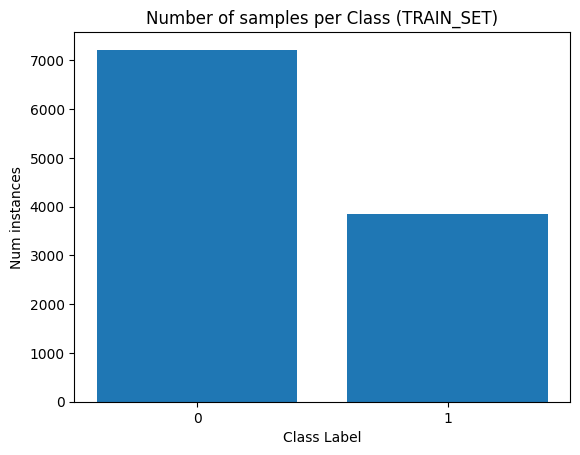

Number of samples per class ( TRAIN_SET ):  {'0': 7217, '1': 3845}


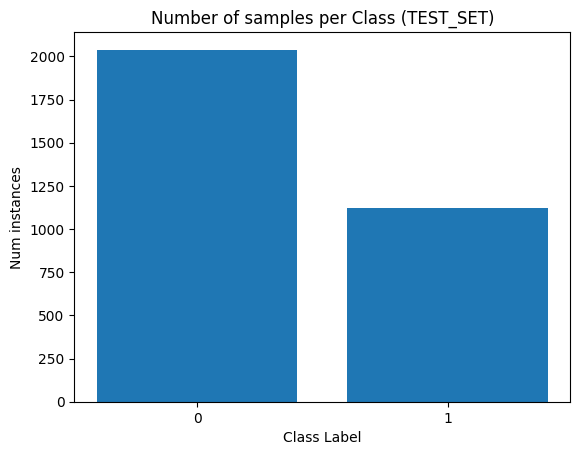

Number of samples per class ( TEST_SET ):  {'0': 2039, '1': 1123}


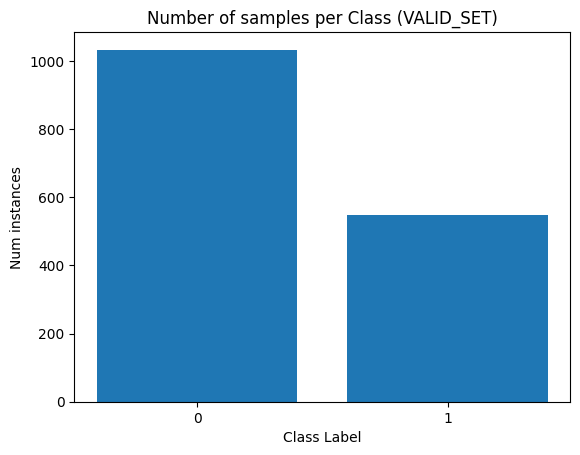

Number of samples per class ( VALID_SET ):  {'0': 1033, '1': 547}


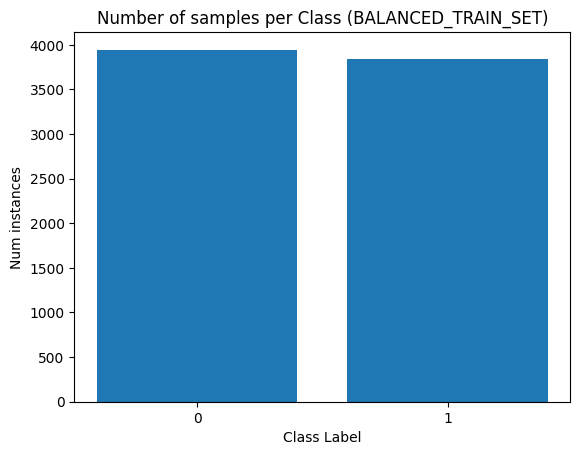

Number of samples per class ( BALANCED_TRAIN_SET ):  {'0': 3945, '1': 3845}
Started the GA from the last saved population


/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1146: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


***************************************************************
Started Genetich Algorithm!
Initialize the population
The input size for the first nn.Linear layer is:  192
Device prima addestrare il modello:  cuda
Il modello si trova sulla GPU.
Ottimizzatore NO in GPU
START TRAINING STEP
Start VALIDATION STEP
Accuracy:  0.6537974683544304 ; Precision:  0.0 ; Recall:  0.0 ; F1:  0.0
Epoch [1] Loss: 0.6952


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Start VALIDATION STEP
Accuracy:  0.34620253164556963 ; Precision:  0.34620253164556963 ; Recall:  1.0 ; F1:  0.5143394452280207
Epoch [2] Loss: 0.6510
Start VALIDATION STEP
Accuracy:  0.34620253164556963 ; Precision:  0.34620253164556963 ; Recall:  1.0 ; F1:  0.5143394452280207
Epoch [3] Loss: 0.6923
Start VALIDATION STEP
Accuracy:  0.34620253164556963 ; Precision:  0.34620253164556963 ; Recall:  1.0 ; F1:  0.5143394452280207
Epoch [4] Loss: 0.6813
Start VALIDATION STEP
Accuracy:  0.34620253164556963 ; Precision:  0.34620253164556963 ; Recall:  1.0 ; F1:  0.5143394452280207
Epoch [5] Loss: 0.6836
Start VALIDATION STEP
Accuracy:  0.34620253164556963 ; Precision:  0.34620253164556963 ; Recall:  1.0 ; F1:  0.5143394452280207
Epoch [6] Loss: 0.6607
Start VALIDATION STEP
Accuracy:  0.34620253164556963 ; Precision:  0.34620253164556963 ; Recall:  1.0 ; F1:  0.5143394452280207
Epoch [7] Loss: 0.7085
Start VALIDATION STEP
Accuracy:  0.34620253164556963 ; Precision:  0.34620253164556963 ; Recal

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Start VALIDATION STEP
Accuracy:  0.34620253164556963 ; Precision:  0.34620253164556963 ; Recall:  1.0 ; F1:  0.5143394452280207
Epoch [10] Loss: 0.6787
Start VALIDATION STEP
Accuracy:  0.34620253164556963 ; Precision:  0.34620253164556963 ; Recall:  1.0 ; F1:  0.5143394452280207
Epoch [11] Loss: 1.2898
Start VALIDATION STEP
Accuracy:  0.34620253164556963 ; Precision:  0.34620253164556963 ; Recall:  1.0 ; F1:  0.5143394452280207
Epoch [12] Loss: 0.6843
Start VALIDATION STEP
Accuracy:  0.34620253164556963 ; Precision:  0.34620253164556963 ; Recall:  1.0 ; F1:  0.5143394452280207
Epoch [13] Loss: 0.6530
Start VALIDATION STEP
Accuracy:  0.34620253164556963 ; Precision:  0.34620253164556963 ; Recall:  1.0 ; F1:  0.5143394452280207
Epoch [14] Loss: 0.7062
Start VALIDATION STEP
Accuracy:  0.34620253164556963 ; Precision:  0.34620253164556963 ; Recall:  1.0 ; F1:  0.5143394452280207
Epoch [15] Loss: 0.7082
Start VALIDATION STEP
Accuracy:  0.34620253164556963 ; Precision:  0.34620253164556963 ;

In [ ]:
#Define dataset
best_path = checkpoint_path = ""
if script_owner:
  initialize_dataset("/content/drive/MyDrive/SE4AI/Model/")
  checkpoint_path = "/content/drive/MyDrive/SE4AI/Model/EvaluationGASecondApproach/Checkpoint.csv"
  best_path = "/content/drive/MyDrive/SE4AI/Model/EvaluationGASecondApproach/BestSolutionGA2.csv"
else:
  initialize_dataset("/content/drive/MyDrive/LinkToOncoVision/SE4AI/Model/")
  checkpoint_path = "/content/drive/MyDrive/LinkToOncoVision/SE4AI/Model/EvaluationGASecondApproach/Checkpoint.csv"
  best_path = "/content/drive/MyDrive/LinkToOncoVision/SE4AI/Model/EvaluationGASecondApproach/BestSolutionGA2.csv"


max_num_generation = 32
fitness = fitness_function_calculator
M = 20 #number of parents to selection step
population_size = 30
chromosomes_size = 14 #learning rate, batch size, num epoch, optimizer, 10 layers
# batch size: 1=32, 2=64, 3=128 ;
# num epoch: 1=64, 2=96, 3=128
# optimizer: 1=Adam, 2=Adadelta, 3=Nadam
# 1=Conv2d and out_channels = 32,
  # 2=Conv2d and out_channels = 16,
  # 3=Conv2d and out_channels = 8,
  # 4=Conv2d and out_channels = 4,
  # 5=MaxPool2d and kernel = 3,
  # 6=MaxPool2d and kernel = 2,
  # 7=AvgPool2d and kernel = 3,
  # 8=AvgPool2d and kernel = 2,
  # 9=Dropout2d,
  # 10=ReLu,
  # 11=LeakyReLu

genes_range = [{'low': 0.001, 'high': 0.1},
               {'low': 1, 'high': 3},
               {'low': 1, 'high': 3},
               {'low': 1, 'high': 3},
               {'low': 1, 'high': 11},
               {'low': 1, 'high': 11},
               {'low': 1, 'high': 11},
               {'low': 1, 'high': 11},
               {'low': 1, 'high': 11},
               {'low': 1, 'high': 11},
               {'low': 1, 'high': 11},
               {'low': 1, 'high': 11},
               {'low': 1, 'high': 11},
               {'low': 1, 'high': 11}
               ]

ga_instance = None
mlflow_id = 0
ga_flag=True

if os.path.exists(checkpoint_path):
  print("Started the GA from the last saved population")
  #This means that Google Colab stopped the Genetic Algorithm, therefore we restart the GA with an initial population equal to the last saved population
  evolution_step = 0
  with open(checkpoint_path, "r", newline="") as csvfile:
    reader = csv.reader(csvfile)
    next(reader) #To jump the file header
    for row in reader:
      evolution_step = int(row[0])
      mlflow_id = int(row[1])

  all_path = population_path = ""
  if script_owner:
    population_path = "/content/drive/MyDrive/SE4AI/Model/EvaluationGASecondApproach/ActualPopulation.csv"
    all_path = "/content/drive/MyDrive/SE4AI/Model/EvaluationGASecondApproach/AllSolutions.csv"
  else:
    population_path = "/content/drive/MyDrive/LinkToOncoVision/SE4AI/Model/EvaluationGASecondApproach/ActualPopulation.csv"
    all_path = "/content/drive/MyDrive/LinkToOncoVision/SE4AI/Model/EvaluationGASecondApproach/AllSolutions.csv"

  #Refresh the max fitness value
  df = pd.read_csv(all_path)
  max_value = df["fitness_value"].max()
  global max_fitness
  max_fitness = float(max_value)

  max_num_generation = max_num_generation - evolution_step

  if max_num_generation == 0:
    #Google stops the GA at the last generation, therefore we must train only the no trained solutions
    ga_flag=False
    train_solutions_last_generation(population_path, best_path, mlflow_id)
  else:
    global num_step
    num_step = evolution_step

    #Load the last stored solutions
    initial_population = []
    with open(population_path, "r", newline="") as csvfile:
      reader = csv.reader(csvfile)
      next(reader) #To jump the file header
      for row in reader:
        learning_rate = float(row[0])
        batch_size = int(float(row[1]))
        num_epoch = int(float(row[2]))
        optimizer = int(float(row[3]))
        layer1 = int(float(row[4]))
        layer2 = int(float(row[5]))
        layer3 = int(float(row[6]))
        layer4 = int(float(row[7]))
        layer5 = int(float(row[8]))
        layer6 = int(float(row[9]))
        layer7 = int(float(row[10]))
        layer8 = int(float(row[11]))
        layer9 = int(float(row[12]))
        layer10 = int(float(row[13]))

        initial_population.append([learning_rate, batch_size, num_epoch, optimizer, layer1, layer2, layer3, layer4, layer5, layer6, layer7, layer8, layer9, layer10])

    initial_population = np.array(initial_population)
    ga_instance = pygad.GA(num_generations = max_num_generation,
                        num_parents_mating = M,
                        fitness_func = fitness,
                        initial_population = initial_population,
                        num_genes = chromosomes_size,
                        gene_type =[[float, 5], int, int, int, int, int, int, int, int, int, int, int, int, int],
                        gene_space = genes_range,
                        parent_selection_type = my_tournament_selection,
                        crossover_type = "two_points", #Two-Point Crossover
                        mutation_type = "random", #Random Resetting -> set a random value within the range
                        mutation_by_replacement = True, #replace the gene by the new randomly generated value
                        mutation_probability = 0.5, #The probability that a gene must exceed in order to be modified
                        stop_criteria= "saturate_16", #Stop criteria: stop the GA if there isn't an improvement after 16 consecutive steps
                        on_start = fun_on_start,
                        save_solutions=True
                        )
else:
  ga_instance = pygad.GA(num_generations = max_num_generation,
                       num_parents_mating = M,
                       fitness_func = fitness,
                       sol_per_pop = population_size,
                       num_genes = chromosomes_size,
                       gene_type =[[float, 5], int, int, int, int, int, int, int, int, int, int, int, int, int],
                       gene_space = genes_range,
                       parent_selection_type = my_tournament_selection,
                       crossover_type = "two_points", #Two-Point Crossover
                       mutation_type = "random", #Random Resetting -> set a random value within the range
                       mutation_by_replacement = True, #replace the gene by the new randomly generated value
                       mutation_probability = 0.5, #The probability that a gene must exceed in order to be modified
                       stop_criteria= "saturate_16", #Stop criteria: stop the GA if there isn't an improvement after 16 consecutive steps
                       on_start = fun_on_start,
                       save_solutions=True
                       )

if ga_flag:
  print("***************************************************************")
  print("Started Genetich Algorithm!")
  if not os.path.exists(checkpoint_path):
    experiment_name = str(input("Insert the experiment name for GA SECOND approach:"))
    mlflow_id = get_experiment_id(experiment_name)

  #Start to track the model with MlFlow
  with mlflow.start_run(experiment_id=mlflow_id):
    ga_instance.run()
    print("GA finished!")
    print("***************************************************************")


  #Save the best solution
  solution, solution_fitness, solution_idx = ga_instance.best_solution()
  print("Parameters of the best solution: ", solution)
  print("Fitness value of the best solution = ", solution_fitness)

  to_write = []
  to_write.extend(solution)
  to_write.append(solution_fitness)
  with open(best_path, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["learning_rate","batch_size","num_epoch","optimizer","layer1","layer2","layer3","layer4","layer5","layer6","layer7","layer8","layer9","layer10", "fitness_value"])
    writer.writerow(to_write)

  #Plot the fitness values, genes, and the explored solutions
  if script_owner:
    ga_instance.plot_fitness(save_dir='/content/drive/MyDrive/SE4AI/Model/EvaluationGASecondApproach/PlotFitnessGA2Approach.png')
    ga_instance.plot_genes(save_dir='/content/drive/MyDrive/SE4AI/Model/EvaluationGASecondApproach/PlotGenesGA2Approach.png')
    ga_instance.plot_new_solution_rate(save_dir='/content/drive/MyDrive/SE4AI/Model/EvaluationGASecondApproach/PlotExploredSolutionsGA2Approach.png')
  else:
    ga_instance.plot_fitness(save_dir='/content/drive/MyDrive/LinkToOncoVision/SE4AI/Model/EvaluationGASecondApproach/PlotFitnessGA2Approach.png')
    ga_instance.plot_genes(save_dir='/content/drive/MyDrive/LinkToOncoVision/SE4AI/Model/EvaluationGASecondApproach/PlotGenesGA2Approach.png')
    ga_instance.plot_new_solution_rate(save_dir='/content/drive/MyDrive/LinkToOncoVision/SE4AI/Model/EvaluationGASecondApproach/PlotExploredSolutionsGA2Approach.png')